# Time Series forecasting with Prophet

In [8]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [9]:
%matplotlib widget
import warnings
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)

In [10]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt


from sqlalchemy import create_engine

# Database connection details
db_config = {
    'user': 'admin',
    'password': 'quest',
    'host': 'questdb',
    'port': 8812, 
    'database': 'qdb'
}

# Create a database connection
engine = create_engine(f'postgresql://{db_config["user"]}:{db_config["password"]}@{db_config["host"]}:{db_config["port"]}/{db_config["database"]}')

In [11]:
# Query to fetch data from your table
query = 'SELECT timestamp, count() FROM github_events sample by 1m align to calendar'

# Read data into a Pandas DataFrame
df = pd.read_sql(query, engine)

# Data exploration (modify as needed)
print(df.head())
df.columns = [ 'ds', 'y']
df

            timestamp  count
0 2024-02-01 23:05:00     30
1 2024-02-02 00:06:00     90
2 2024-02-02 00:07:00    180
3 2024-02-02 00:08:00    180
4 2024-02-02 00:09:00    150


,ds,y
0,2024-02-01 23:05:00,30
1,2024-02-02 00:06:00,90
2,2024-02-02 00:07:00,180
3,2024-02-02 00:08:00,180
4,2024-02-02 00:09:00,150
5,2024-02-02 00:10:00,180


In [12]:
# Creating and fitting the Prophet model
model = Prophet()
model.fit(df)

00:11:03 - cmdstanpy - INFO - Chain [1] start processing
00:11:03 - cmdstanpy - INFO - Chain [1] done processing


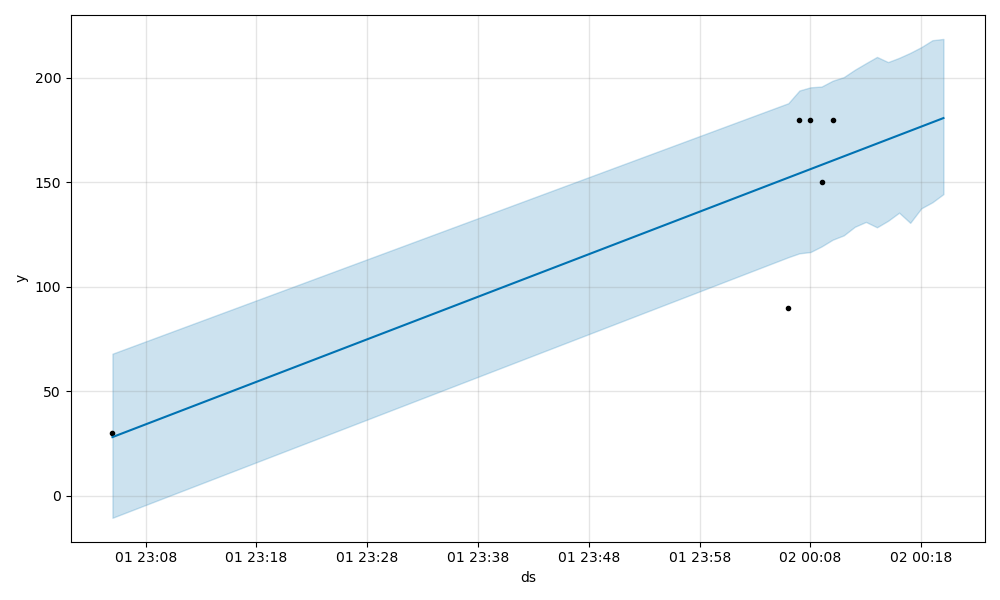

In [13]:
# Making future predictions
#future = model.make_future_dataframe(periods=30)  # Predicting 30 days into the future
future = model.make_future_dataframe(periods=10, freq='T')
forecast = model.predict(future)

# Plotting the forecast
model.plot(forecast)
plt.show()

# Time Series Forecasting with Sklearn and Linear Regression

In [14]:
%matplotlib widget

from sqlalchemy import create_engine
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Database connection details
db_config = {
    'user': 'admin',
    'password': 'quest',
    'host': 'questdb',
    'port': 8812, 
    'database': 'qdb'
}

# Create a database connection
engine = create_engine(f'postgresql://{db_config["user"]}:{db_config["password"]}@{db_config["host"]}:{db_config["port"]}/{db_config["database"]}')

# SQL query to retrieve data from the "github_events" table with downsampling
query = 'SELECT timestamp, count() FROM github_events sample by 1m'

# Execute the query and fetch data into a DataFrame
df = pd.read_sql(query, engine)

# Data preprocessing
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

In [15]:
# Create feature (X) and target (y) datasets
X = df.index.to_julian_date().values.reshape(-1, 1)
y = df['count'].values
df

,count
timestamp,
2024-02-01 23:05:33.727663,30
2024-02-02 00:05:33.727663,30
2024-02-02 00:06:33.727663,180
2024-02-02 00:07:33.727663,150
2024-02-02 00:08:33.727663,180
2024-02-02 00:09:33.727663,180
2024-02-02 00:10:33.727663,90


In [16]:
# Create and fit a Linear Regression model
model = LinearRegression()
model.fit(X, y)

LinearRegression()

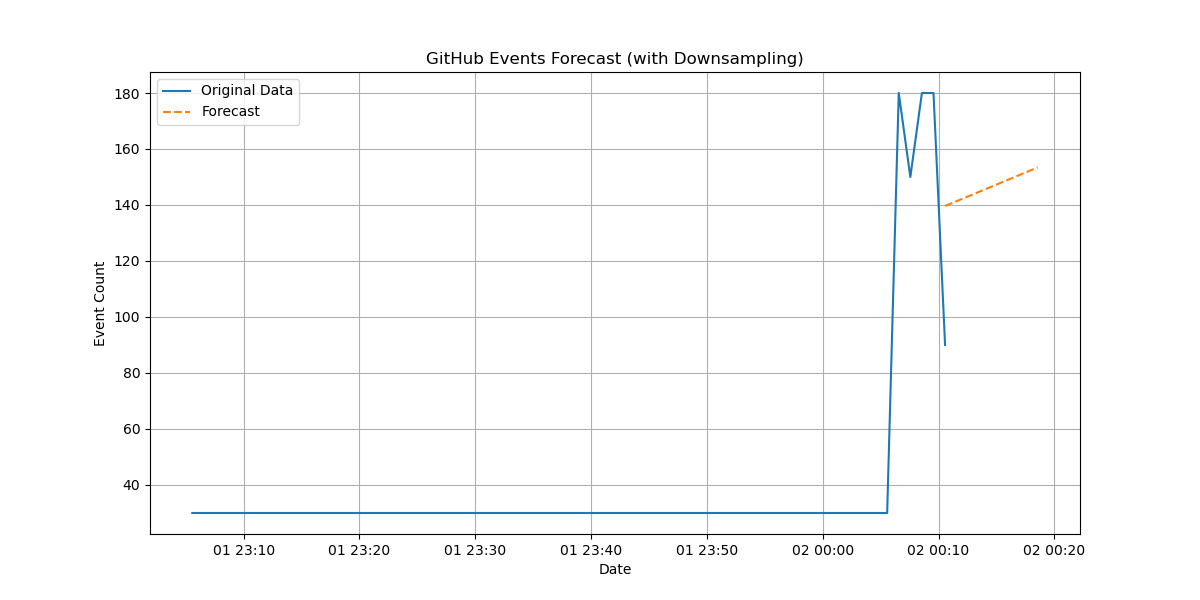

In [17]:
# Predict future values
future_minutes = 10 #30 * 24 * 60  # Number of minutes to forecast (30 days)
future_dates = pd.date_range(start=df.index[-1], periods=future_minutes, freq='T')
future_dates_jd = future_dates.to_julian_date().values.reshape(-1, 1)
future_forecast = model.predict(future_dates_jd)

# Exclude the last known date from the forecast
future_dates = future_dates[:-1]
future_forecast = future_forecast[:-1]

# Plot the original data and the forecast
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['count'], label='Original Data')
plt.plot(future_dates, future_forecast, label='Forecast', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Event Count')
plt.title('GitHub Events Forecast (with Downsampling)')
plt.legend()
plt.grid()
plt.show()